In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn import tree


## Data Acquisition
##### Flat Acquisition using csv files

In [2]:
movies = pd.read_csv('./data/movies.csv')
# genome_scores = pd.read_csv('./data/genome-scores.csv')
# genome_tags = pd.read_csv('./data/genome-tags.csv')
ratings = pd.read_csv('./data/ratings.csv')
tags = pd.read_csv('./data/tags.csv')

In [3]:
# print the first 5 rows of the movies, ratings, and tags dataframes
display(movies.head())
display(ratings.head())
display(tags.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [4]:
""" # show scatter plot of rating
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(y='rating', x='movieId', data=ratings, ax=ax)
plt.show() """

" # show scatter plot of rating\nfig, ax = plt.subplots(figsize=(5, 5))\nsns.scatterplot(y='rating', x='movieId', data=ratings, ax=ax)\nplt.show() "

In [5]:
""" # show scatter plot of rating
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(y='timestamp', x='movieId', data=ratings, ax=ax)
plt.show() """

" # show scatter plot of rating\nfig, ax = plt.subplots(figsize=(5, 5))\nsns.scatterplot(y='timestamp', x='movieId', data=ratings, ax=ax)\nplt.show() "

In [6]:
""" # show scatter plot of rating
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(y='timestamp', x='movieId', data=tags, ax=ax)
plt.show() """

" # show scatter plot of rating\nfig, ax = plt.subplots(figsize=(5, 5))\nsns.scatterplot(y='timestamp', x='movieId', data=tags, ax=ax)\nplt.show() "

### Data Wrangling

In [7]:
grouped_ratings = ratings.groupby('movieId').agg({'rating': ['mean', 'count'], 'timestamp': ['mean']})
grouped_ratings.columns = ['mean_rating', 'rating_count', 'mean_timestamp']
grouped_ratings = grouped_ratings.astype({'mean_timestamp': 'int'})

# Merge dei dataset movies e ratings
# rimuove i film che non hanno rating
movies_ratings = pd.merge(movies, grouped_ratings, on='movieId')

# mantiene i duplicati, per rimuoverli usare .apply[set, list]
# tags.groupby('movieId')['tag'].apply(set)
new_tags = tags.groupby('movieId')['tag'].apply(set).apply(list)

df = pd.merge(movies_ratings, new_tags, on='movieId')

display(df.head())


,movieId,title,genres,mean_rating,rating_count,mean_timestamp,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210,"[ya boy, fanciful, rivalry, Want, pixar, Tim A..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117,"[see also:Zathura, childish, based on a book, ..."
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256,"[grun running, duringcreditsstinger, Sophia Lo..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471,"[characters, chick flick, CLV, divorce, interr..."
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013,"[parent child relationship, contraception, pre..."


### Data Preparation (Data cleaning, Duplicates filtering, Data encoding)

##### Data Cleaning
The following results show that there are no NaN values in the dataset.

In [8]:
# print number of rows
print('Number of rows: ', df.shape[0])

# drop rows with missing values
df = df.dropna()

# print number of rows after dropping missing values
print('Number of rows after dropping missing values: ', df.shape[0])


Number of rows:  41875
Number of rows after dropping missing values:  41875


##### Data Encoding
Multicategorical One-Hot encoding for film genres

In [9]:
# one hot encoding for genres
# print every category in movies dataset
categories = set()
for s in df['genres'].str.split('|').values:
    categories = categories.union(set(s))

# remove (no genres listed) from categories
categories.remove('(no genres listed)')

# add columns for each category
for category in categories:
    df[category] = df['genres'].str.contains(category).astype(int)

# delete genres column
df = df.drop(columns=['genres'])

display(df.head())

,movieId,title,mean_rating,rating_count,mean_timestamp,tag,Fantasy,Animation,Crime,Horror,...,Mystery,Comedy,Sci-Fi,Drama,Thriller,Children,IMAX,Action,War,Western
0,1,Toy Story (1995),3.893708,57309,1153152210,"[ya boy, fanciful, rivalry, Want, pixar, Tim A...",1,1,0,0,...,0,1,0,0,0,1,0,0,0,0
1,2,Jumanji (1995),3.251527,24228,1122310117,"[see also:Zathura, childish, based on a book, ...",1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,Grumpier Old Men (1995),3.142028,11804,980602256,"[grun running, duringcreditsstinger, Sophia Lo...",0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),2.853547,2523,942460471,"[characters, chick flick, CLV, divorce, interr...",0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),3.058434,11714,1004723013,"[parent child relationship, contraception, pre...",0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


##### Duplicates Filtering
The following results show that there are no duplicates in the dataset (as expected after merge operation).

In [10]:
df = df.copy()

# drop tag column TODO: find a way to use tag
df = df.drop(columns=['tag'])

# print number of rows
print('Number of rows: ', df.shape[0])

# drop duplicated rows
df = df.drop_duplicates()

# print number of rows after dropping missing values
print('Number of rows after dropping duplicated rows: ', df.shape[0])


Number of rows:  41875
Number of rows after dropping duplicated rows:  41875


## Data Visualization

In [11]:
""" # rating distribution from ratings.csv
sns.countplot(x='rating', data=ratings)
plt.show()

sns.boxplot(x='rating', data=ratings)
plt.show() """

" # rating distribution from ratings.csv\nsns.countplot(x='rating', data=ratings)\nplt.show()\n\nsns.boxplot(x='rating', data=ratings)\nplt.show() "

Rather than using discrete bins, a KDE plot smooths the observations with a Gaussian kernel, producing a continuous density estimate. This is used for continuous attributes like rating mean.

It is done to show differences after data aggregation in calculating mean for each film.

In [12]:
""" # rating distribution from df
sns.kdeplot(df['mean_rating'])
plt.xlabel('rating mean for film')
plt.title('Rating distribution in dataframe')
plt.show() """

" # rating distribution from df\nsns.kdeplot(df['mean_rating'])\nplt.xlabel('rating mean for film')\nplt.title('Rating distribution in dataframe')\nplt.show() "

Observing the distribution of all attributes for every file.

This is useful to show data trends, to reveal outliers and leverage points, to provide hints about modeling techniques to apply.


In [13]:
""" # print distribution for ratings
fig, axs = plt.subplots(3)
sns.kdeplot(ratings['timestamp'], ax=axs[0], color='r', label='timestamp')
sns.kdeplot(ratings['rating'], ax=axs[1], color='b', label='rating')
sns.kdeplot(ratings['movieId'], ax=axs[2], color='g', label='movieId')

axs[0].set_xlabel('timestamp')
axs[1].set_xlabel('rating')
axs[2].set_xlabel('movieId')
plt.show() """

" # print distribution for ratings\nfig, axs = plt.subplots(3)\nsns.kdeplot(ratings['timestamp'], ax=axs[0], color='r', label='timestamp')\nsns.kdeplot(ratings['rating'], ax=axs[1], color='b', label='rating')\nsns.kdeplot(ratings['movieId'], ax=axs[2], color='g', label='movieId')\n\naxs[0].set_xlabel('timestamp')\naxs[1].set_xlabel('rating')\naxs[2].set_xlabel('movieId')\nplt.show() "

In [14]:
""" movies_to_show = 5
fig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))

most_rated_movies = ratings.groupby('movieId').count().sort_values('rating', ascending=False).head(movies_to_show).index

to_line_plot = []
for i in range(movies_to_show):
    tmp = ratings.where(ratings['movieId'] == most_rated_movies[i]).dropna()
    tmp['date'] = pd.to_datetime(tmp['timestamp'], unit='s')
    
    # Computing the mean for each month
    tmp = tmp.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    to_line_plot.append(tmp)
    movie_title = movies.where(movies['movieId'] == most_rated_movies[i]).dropna()['title'].values[0]
    axs[i].set_title("Movie: '" + movie_title + "'")
    

for i in range(movies_to_show):
    sns.lineplot(x='date', y='rating', ax=axs[i], data=to_line_plot[i])

fig.suptitle('Rating evolution for the 5 most rated movies')
plt.show() """

' movies_to_show = 5\nfig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))\n\nmost_rated_movies = ratings.groupby(\'movieId\').count().sort_values(\'rating\', ascending=False).head(movies_to_show).index\n\nto_line_plot = []\nfor i in range(movies_to_show):\n    tmp = ratings.where(ratings[\'movieId\'] == most_rated_movies[i]).dropna()\n    tmp[\'date\'] = pd.to_datetime(tmp[\'timestamp\'], unit=\'s\')\n    \n    # Computing the mean for each month\n    tmp = tmp.resample("M", on=\'date\').mean()[[\'movieId\', \'rating\']].dropna()\n    to_line_plot.append(tmp)\n    movie_title = movies.where(movies[\'movieId\'] == most_rated_movies[i]).dropna()[\'title\'].values[0]\n    axs[i].set_title("Movie: \'" + movie_title + "\'")\n    \n\nfor i in range(movies_to_show):\n    sns.lineplot(x=\'date\', y=\'rating\', ax=axs[i], data=to_line_plot[i])\n\nfig.suptitle(\'Rating evolution for the 5 most rated movies\')\nplt.show() '

In [15]:
""" # Same as above cell but the 3 movies with the highest standard deviation
movies_to_show = 3
fig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))

# Take movies with at least 1000 ratings
high_std_movies = ratings.where(
    ratings['movieId']
    .isin(ratings.groupby('movieId')
          .count()
          .where(ratings.groupby('movieId').count()['rating'] > 1000)
          .dropna().index)
    ).dropna()

# most_rated_movies = ratings.groupby('movieId').count().sort_values('rating', ascending=False).head(movies_to_show).index
high_std_movies = high_std_movies.groupby('movieId').std().sort_values('rating', ascending=False).head(movies_to_show).index

to_line_plot = []
for i in range(movies_to_show):
    tmp = ratings.where(ratings['movieId'] == high_std_movies[i]).dropna()
    tmp['date'] = pd.to_datetime(tmp['timestamp'], unit='s')
    
    # Computing the mean for each month
    tmp = tmp.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    to_line_plot.append(tmp)
    movie_title = movies.where(movies['movieId'] == high_std_movies[i]).dropna()['title'].values[0]
    axs[i].set_title("Movie: '" + movie_title + "'")

for i in range(movies_to_show):
    sns.lineplot(x='date', y='rating', ax=axs[i], data=to_line_plot[i])

# Print the titles of the movies
plt.show() """

' # Same as above cell but the 3 movies with the highest standard deviation\nmovies_to_show = 3\nfig, axs = plt.subplots(movies_to_show, sharex=True, sharey=True, figsize=(10, 10))\n\n# Take movies with at least 1000 ratings\nhigh_std_movies = ratings.where(\n    ratings[\'movieId\']\n    .isin(ratings.groupby(\'movieId\')\n          .count()\n          .where(ratings.groupby(\'movieId\').count()[\'rating\'] > 1000)\n          .dropna().index)\n    ).dropna()\n\n# most_rated_movies = ratings.groupby(\'movieId\').count().sort_values(\'rating\', ascending=False).head(movies_to_show).index\nhigh_std_movies = high_std_movies.groupby(\'movieId\').std().sort_values(\'rating\', ascending=False).head(movies_to_show).index\n\nto_line_plot = []\nfor i in range(movies_to_show):\n    tmp = ratings.where(ratings[\'movieId\'] == high_std_movies[i]).dropna()\n    tmp[\'date\'] = pd.to_datetime(tmp[\'timestamp\'], unit=\'s\')\n    \n    # Computing the mean for each month\n    tmp = tmp.resample("M", 

Plot density for every attribute of dataset

In [16]:
""" # density plot for rating_count
fig, axs = plt.subplots(1,2, figsize=(10, 5))
sns.kdeplot(df['rating_count'], ax=axs[0], label='rating_count')
sns.kdeplot(df['rating_count'].where(df['rating_count'] < 50), ax=axs[1], label='rating_count < 50')

print('Number of movies with rating_count < 50: ', df.where(df['rating_count'] < 50).count()[0])
print('Number of all movies: ', df.shape[0]) """

" # density plot for rating_count\nfig, axs = plt.subplots(1,2, figsize=(10, 5))\nsns.kdeplot(df['rating_count'], ax=axs[0], label='rating_count')\nsns.kdeplot(df['rating_count'].where(df['rating_count'] < 50), ax=axs[1], label='rating_count < 50')\n\nprint('Number of movies with rating_count < 50: ', df.where(df['rating_count'] < 50).count()[0])\nprint('Number of all movies: ', df.shape[0]) "

In [17]:
""" # density plot for rating year

df_timestamp = df.copy()

# convert timestamp to year
df_timestamp['year_timestamp'] = pd.to_datetime(df_timestamp['mean_timestamp'], unit='s').dt.year

# delete mean_timestamp column to avoid redundancy - TODO check if it is better to keep it
df_timestamp = df_timestamp.drop(columns=['mean_timestamp'])

sns.kdeplot(df['year_timestamp'])
plt.show() """

" # density plot for rating year\n\ndf_timestamp = df.copy()\n\n# convert timestamp to year\ndf_timestamp['year_timestamp'] = pd.to_datetime(df_timestamp['mean_timestamp'], unit='s').dt.year\n\n# delete mean_timestamp column to avoid redundancy - TODO check if it is better to keep it\ndf_timestamp = df_timestamp.drop(columns=['mean_timestamp'])\n\nsns.kdeplot(df['year_timestamp'])\nplt.show() "

In [18]:
""" 
# TODO - change visualization to show the relevance for each movie-tag
# plot for categories
cat = list(categories)

# count the number of rows containing 1 for each category
cat_dict = {}
for category in cat:
    cat_dict[category] = df[category].sum()

# order the dictionary by value in descending order
cat_dict = {k: v for k, v in sorted(cat_dict.items(), key=lambda item: item[1], reverse=True)}

# plot an histogram of the number of rows for each category
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.barplot(x=list(cat_dict.keys()), y=list(cat_dict.values()))
ax.bar_label(container=ax.containers[0], labels=list(cat_dict.keys()))
plt.xticks([])
plt.show()

print('List of attributes: ', list(df.columns))
 """

" \n# TODO - change visualization to show the relevance for each movie-tag\n# plot for categories\ncat = list(categories)\n\n# count the number of rows containing 1 for each category\ncat_dict = {}\nfor category in cat:\n    cat_dict[category] = df[category].sum()\n\n# order the dictionary by value in descending order\ncat_dict = {k: v for k, v in sorted(cat_dict.items(), key=lambda item: item[1], reverse=True)}\n\n# plot an histogram of the number of rows for each category\nfig, axs = plt.subplots(1, 1, figsize=(20, 10))\nax = sns.barplot(x=list(cat_dict.keys()), y=list(cat_dict.values()))\nax.bar_label(container=ax.containers[0], labels=list(cat_dict.keys()))\nplt.xticks([])\nplt.show()\n\nprint('List of attributes: ', list(df.columns))\n "

In [19]:
""" # count the number of rows containing 1 for Film-Noir and IMAX
print('Number of Film-Noir movies: ', df['Film-Noir'].sum())
print('Number of IMAX movies: ', df['IMAX'].sum())
 """

" # count the number of rows containing 1 for Film-Noir and IMAX\nprint('Number of Film-Noir movies: ', df['Film-Noir'].sum())\nprint('Number of IMAX movies: ', df['IMAX'].sum())\n "

In [20]:
""" # compute the ratio of mismatches for each category

# count the number of rows
total_rows = df.shape[0]

mismatches = {}
# remove (no genres listed) from list categories
cat = list(categories)

for category1 in cat:
    for category2 in cat:
        if category1 != category2:
            # count the number of rows where category1 and category2 are both 1
            count = df.where((df[category1] == 1) & (df[category2] == 1)).count()[0]
            if count > 0:
                # if there are rows where category1 and category2 are both 1, add the ratio to the dictionary
                mismatches[category1 + ' - ' + category2] = (total_rows - count) / total_rows

# order the dictionary by value in descending order and print it
mismatches = {k: v for k, v in sorted(mismatches.items(), key=lambda item: item[1], reverse=False)}
display('Mismatches: ', mismatches) """


" # compute the ratio of mismatches for each category\n\n# count the number of rows\ntotal_rows = df.shape[0]\n\nmismatches = {}\n# remove (no genres listed) from list categories\ncat = list(categories)\n\nfor category1 in cat:\n    for category2 in cat:\n        if category1 != category2:\n            # count the number of rows where category1 and category2 are both 1\n            count = df.where((df[category1] == 1) & (df[category2] == 1)).count()[0]\n            if count > 0:\n                # if there are rows where category1 and category2 are both 1, add the ratio to the dictionary\n                mismatches[category1 + ' - ' + category2] = (total_rows - count) / total_rows\n\n# order the dictionary by value in descending order and print it\nmismatches = {k: v for k, v in sorted(mismatches.items(), key=lambda item: item[1], reverse=False)}\ndisplay('Mismatches: ', mismatches) "

In [21]:
""" from scipy.spatial.distance import pdist, squareform
# compute the distance matrix for categories
display(df.head())
categories_df = df[df.drop(columns=['movieId', 'title', 'mean_rating', 'rating_count', 'tag', 'year_timestamp']).columns]
display(categories_df.head())

dist_matrix = pdist(categories_df, 'cosine')

# Create a pandas DataFrame to represent the distance matrix
df_dist = pd.DataFrame(squareform(dist_matrix), columns=np.arange(categories_df.shape[0]), index=np.arange(categories_df.shape[0]))

# Print the DataFrame with observation labels
obs_labels = ['Obs{}'.format(i) for i in range(categories_df.shape[0])]
df_dist.index = obs_labels
df_dist.columns = obs_labels
display(df_dist.head())

# show only rows with at least two columns with value 0
mask = (df_dist == 0).sum(axis=1) >= 2
result = df_dist.loc[mask].dropna(axis=1)
display(result.head())

# print(result[0:1].where(result[0:1] == 0).dropna(axis=1))

print('Number of rows with at least two columns with value 0: ', result.shape[0], ' out of ', df_dist.shape[0])
 """

" from scipy.spatial.distance import pdist, squareform\n# compute the distance matrix for categories\ndisplay(df.head())\ncategories_df = df[df.drop(columns=['movieId', 'title', 'mean_rating', 'rating_count', 'tag', 'year_timestamp']).columns]\ndisplay(categories_df.head())\n\ndist_matrix = pdist(categories_df, 'cosine')\n\n# Create a pandas DataFrame to represent the distance matrix\ndf_dist = pd.DataFrame(squareform(dist_matrix), columns=np.arange(categories_df.shape[0]), index=np.arange(categories_df.shape[0]))\n\n# Print the DataFrame with observation labels\nobs_labels = ['Obs{}'.format(i) for i in range(categories_df.shape[0])]\ndf_dist.index = obs_labels\ndf_dist.columns = obs_labels\ndisplay(df_dist.head())\n\n# show only rows with at least two columns with value 0\nmask = (df_dist == 0).sum(axis=1) >= 2\nresult = df_dist.loc[mask].dropna(axis=1)\ndisplay(result.head())\n\n# print(result[0:1].where(result[0:1] == 0).dropna(axis=1))\n\nprint('Number of rows with at least two col

In [22]:
""" from scipy.spatial.distance import squareform

# Create a pandas DataFrame to represent the distance matrix
df_dist = pd.DataFrame(squareform(dist_matrix), columns=np.arange(categories_df.shape[0]), index=np.arange(categories_df.shape[0]))

# Print the DataFrame with observation labels
obs_labels = ['Obs{}'.format(i) for i in range(categories_df.shape[0])]
df_dist.index = obs_labels
df_dist.columns = obs_labels
display(df_dist.head())

# show only rows with at least two columns with value 0
mask = (df_dist == 0).sum(axis=1) >= 2
result = df_dist.loc[mask].dropna(axis=1)
display(result.head())

# print(result[0:1].where(result[0:1] == 0).dropna(axis=1))

print('Number of rows with at least two columns with value 0: ', result.shape[0], ' out of ', df_dist.shape[0]) """

" from scipy.spatial.distance import squareform\n\n# Create a pandas DataFrame to represent the distance matrix\ndf_dist = pd.DataFrame(squareform(dist_matrix), columns=np.arange(categories_df.shape[0]), index=np.arange(categories_df.shape[0]))\n\n# Print the DataFrame with observation labels\nobs_labels = ['Obs{}'.format(i) for i in range(categories_df.shape[0])]\ndf_dist.index = obs_labels\ndf_dist.columns = obs_labels\ndisplay(df_dist.head())\n\n# show only rows with at least two columns with value 0\nmask = (df_dist == 0).sum(axis=1) >= 2\nresult = df_dist.loc[mask].dropna(axis=1)\ndisplay(result.head())\n\n# print(result[0:1].where(result[0:1] == 0).dropna(axis=1))\n\nprint('Number of rows with at least two columns with value 0: ', result.shape[0], ' out of ', df_dist.shape[0]) "

In [23]:
""" # show hist plot for mean_rating-genres
fig, axs = plt.subplots(10, 2, figsize=(15, 20))
# create a df with only mean_rating and genres where genres are 1
cat = list(categories)
for category in cat:
    df_genre = df[df[category] == 1]
    if cat.index(category) < 10:
        sns.kdeplot(df_genre['mean_rating'], ax=axs[cat.index(category), 0], label=category)
    else:
        sns.kdeplot(df_genre['mean_rating'], ax=axs[cat.index(category)-10, 1], label=category)

plt.show() """


" # show hist plot for mean_rating-genres\nfig, axs = plt.subplots(10, 2, figsize=(15, 20))\n# create a df with only mean_rating and genres where genres are 1\ncat = list(categories)\nfor category in cat:\n    df_genre = df[df[category] == 1]\n    if cat.index(category) < 10:\n        sns.kdeplot(df_genre['mean_rating'], ax=axs[cat.index(category), 0], label=category)\n    else:\n        sns.kdeplot(df_genre['mean_rating'], ax=axs[cat.index(category)-10, 1], label=category)\n\nplt.show() "

## Data Preprocessing

In [24]:
# from title extract year
df['year'] = df['title'].str.extract('(\(\d{4}\))', expand=True)
# remove parentheses
df['year'] = df['year'].str.extract('(\d{4})', expand=True)
# convert year to int
df['year'] = df['year']

# remove movies with no year
df = df.dropna(subset=['year'])

# delete title and movieId columns
df = df.drop(columns=['movieId', 'title'])

display(df.head())

,mean_rating,rating_count,mean_timestamp,Fantasy,Animation,Crime,Horror,Musical,Adventure,Documentary,...,Comedy,Sci-Fi,Drama,Thriller,Children,IMAX,Action,War,Western,year
0,3.893708,57309,1153152210,1,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1995
1,3.251527,24228,1122310117,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1995
2,3.142028,11804,980602256,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1995
3,2.853547,2523,942460471,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1995
4,3.058434,11714,1004723013,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1995


In [25]:
""" # density plot for film year
sns.kdeplot(df['year'])
plt.show() """

" # density plot for film year\nsns.kdeplot(df['year'])\nplt.show() "

### Correlation results
This correlation table shows the relationship between different movie genres and several movie characteristics such as mean rating, rating count, and year of release. The values in the table represent the Pearson correlation coefficient, which ranges from -1 to 1 and measures the linear association between two variables. Positive values indicate a positive association, meaning that as one variable increases, the other variable also increases. Negative values indicate a negative association, meaning that as one variable increases, the other variable decreases.

Some observations from the table:

There is a positive correlation between the mean rating and rating count of a movie (0.13). This indicates that movies with higher ratings tend to have more ratings.
Film-Noir has a moderate positive correlation with Crime (0.15) and Mystery (0.06). This suggests that movies classified as Film-Noir often have elements of crime and mystery.
Horror movies have a negative correlation with mean rating (-0.22), indicating that they tend to have lower ratings.
Drama movies have a moderate positive correlation with mean rating (0.15) and a moderate positive correlation with Thriller movies (0.24).
There is a negative correlation between year of release and rating count (-0.27), which suggests that older movies tend to have fewer ratings.
In conclusion, this table provides useful information about the relationship between different movie genres and movie characteristics, and can be used to make informed decisions about movie selection and production.


### Covariance results
Covariance is a measure of the linear relationship between two variables. It measures how changes in one variable are associated with changes in the other variable. Covariance is expressed as a numerical value and can range from negative to positive values. A positive covariance means that the two variables are positively related, while a negative covariance means that they are inversely related. A covariance of zero means that there is no linear relationship between the variables (i.e. variables are indipendent).

In the table provided, the covariance between two variables can be found in the entries of the matrix. For example, the covariance between "mean_rating" and "Film-Noir" is 0.001774, indicating a very small positive relationship between the two variables. The covariance between "rating_count" and "Crime" is 43.331685, indicating a stronger positive relationship between these two variables.

It's important to keep in mind that covariance only measures linear relationships, so it may not be able to fully capture more complex relationships between variables.

As it's possible to see in the table, variables tend to be indipendent from each others, this is not valid only for two variables: rating_count and mean_timestamp. These two attributes are highly dipendent with all other attributes.

### Dataset Describe
The describe() function applied on the Pandas DataFrame provides statistical information about the features in the DataFrame. According to the results, the mean rating for the movies is 3.110263, with a standard deviation of 0.653225. The minimum and maximum ratings are 0.5 and 5, respectively. The mean count of ratings for each movie is 596.81, with a standard deviation of 2929.96.

The genre columns (Film-Noir, Crime, Mystery, Animation, etc.) are binary, with a mean of either 0 or 0.01 to 0.28. The 25th, 50th, and 75th percentiles for these features are either 0 or close to 0, indicating that the majority of the movies belong to a particular genre. The year_timestamp feature has a mean of 2014.22, with a standard deviation of 4.7. The year feature has a mean of 1991.57 and a standard deviation of 25.09.

/var/folders/x8/p0tjyw5163s2pb2vfft_2jbc0000gn/T/ipykernel_5845/3978950111.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
/var/folders/x8/p0tjyw5163s2pb2vfft_2jbc0000gn/T/ipykernel_5845/3978950111.py:4: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cov = df.cov()


                mean_rating  rating_count  mean_timestamp   Fantasy  \
mean_rating        1.000000      0.132640       -0.063164 -0.018992   
rating_count       0.132640      1.000000       -0.270657  0.058577   
mean_timestamp    -0.063164     -0.270657        1.000000  0.010713   
Fantasy           -0.018992      0.058577        0.010713  1.000000   
Animation          0.020720      0.016321        0.087082  0.152592   
Crime              0.015203      0.050338       -0.034568 -0.058943   
Horror            -0.224045     -0.020006        0.049882  0.032483   
Musical            0.022940      0.020285       -0.093946  0.036938   
Adventure         -0.028135      0.122405       -0.043006  0.208756   
Documentary        0.149778     -0.053596        0.066459 -0.068747   
Romance            0.043127      0.026379       -0.073011  0.009709   
Film-Noir          0.030073      0.003847       -0.036048 -0.017374   
Mystery           -0.012221      0.026069        0.003005  0.015703   
Comedy

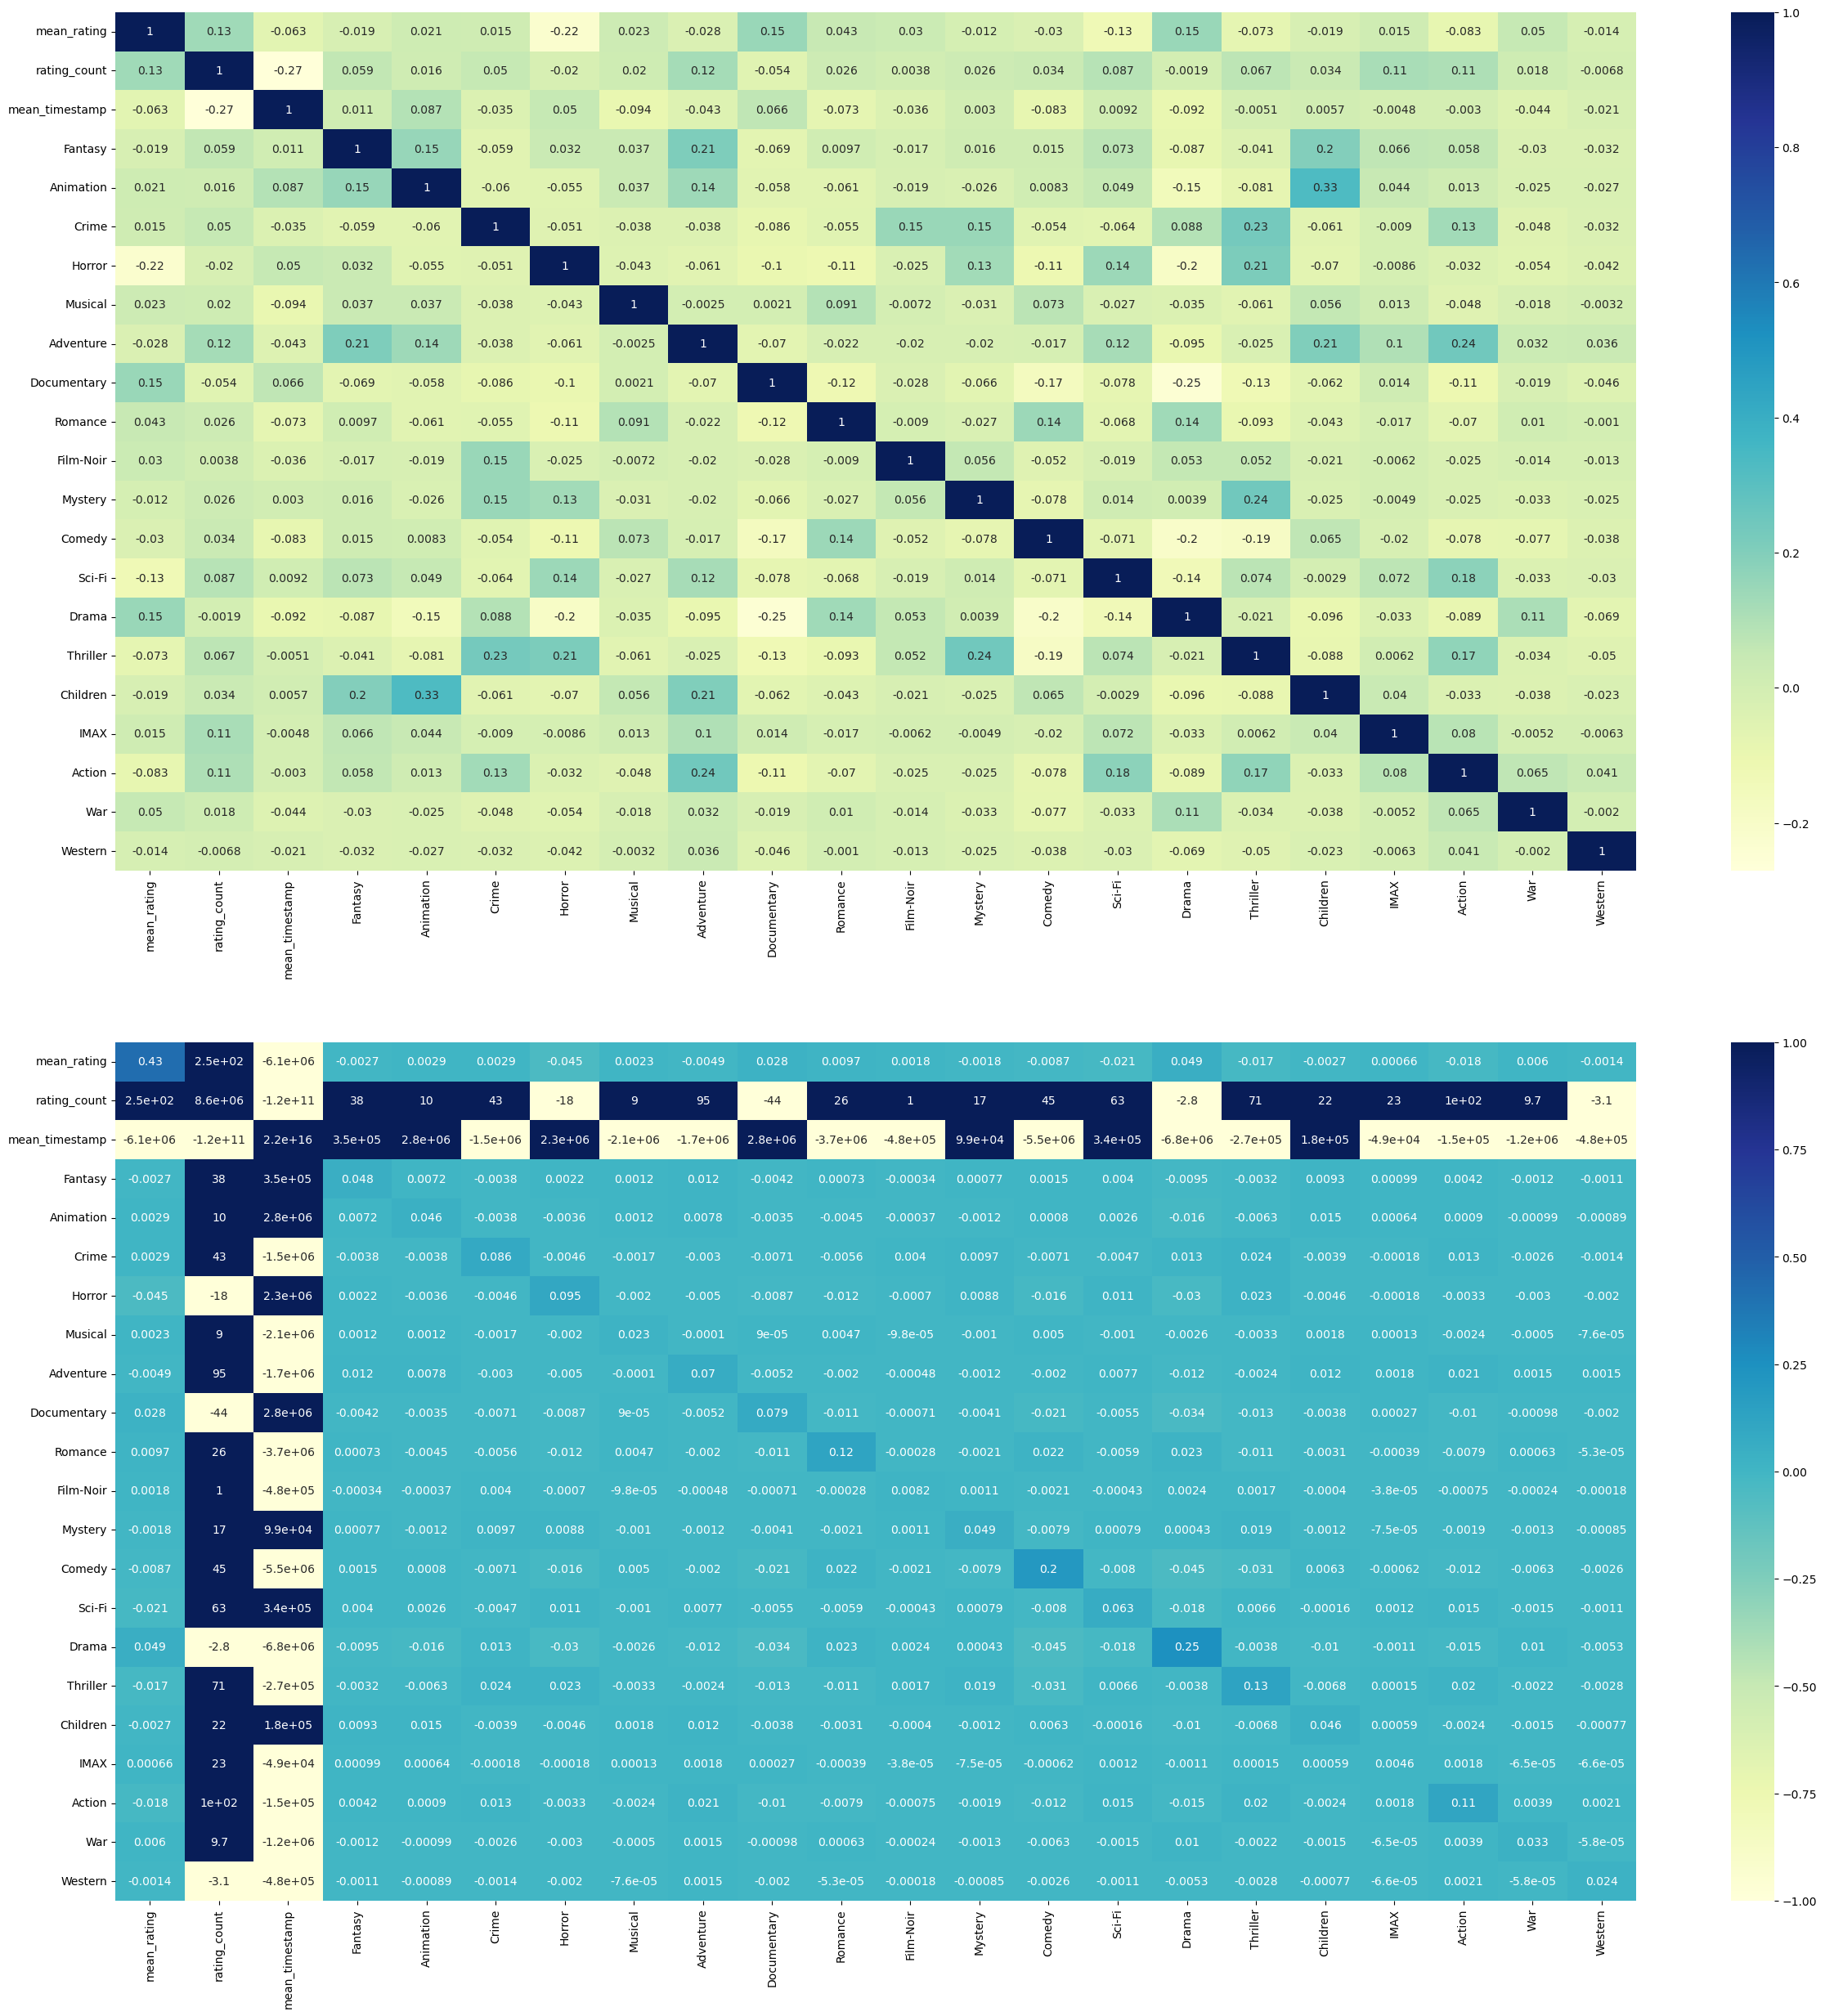

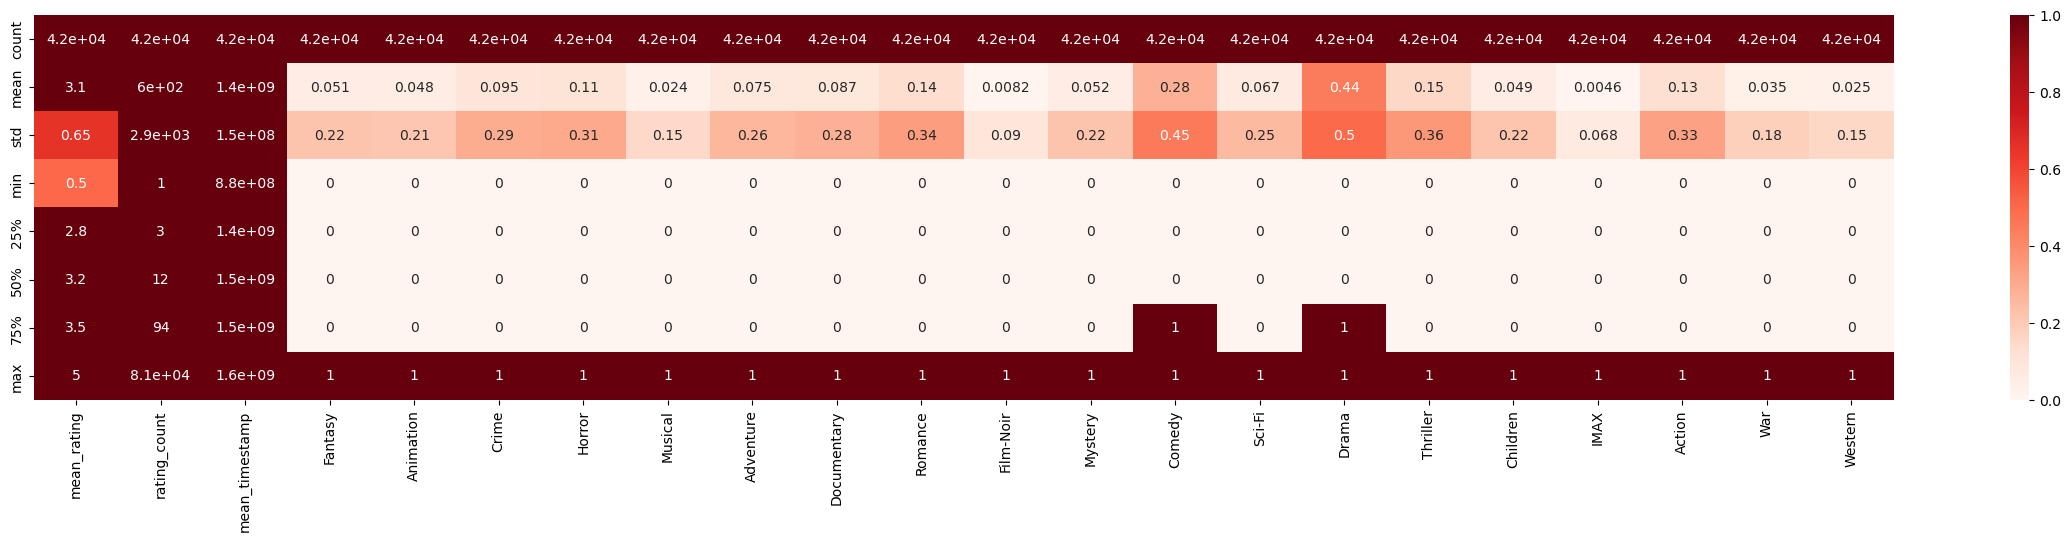

In [26]:
# compute analysis between attributes of the dataset
corr = df.corr()
print(corr)
cov = df.cov()
print(cov)
desc = df.describe()
print(desc)

# follow examples from slides on Data Visualization (pages 6-8)
fig, axs = plt.subplots(2, 1, figsize=(30, 30))
# show results of correlation in a graphic way
# Plot the heatmap of the correlation matrix
sns.heatmap(corr, annot=True, cmap="YlGnBu", ax=axs[0])
# show results of covariance in a graphic way
# Plot the heatmap of the covariance matrix
sns.heatmap(cov, annot=True, cmap="YlGnBu", ax=axs[1], vmax=1, vmin=-1)

plt.show()

# Plot the table
plt.figure(figsize=(30, 5))
sns.heatmap(desc, annot=True, cmap='Reds', vmax=1, vmin=0)
plt.show()


In [27]:
""" # show scatter plot for mean_rating-attributes

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(x='rating_count', y='mean_rating', data=df, ax=axs[0, 0])
sns.scatterplot(x='year', y='mean_rating', data=df, ax=axs[0, 1])
sns.scatterplot(x='year_timestamp', y='mean_rating', data=df, ax=axs[1, 0])
plt.show()
 """

" # show scatter plot for mean_rating-attributes\n\nfig, axs = plt.subplots(2, 2, figsize=(15, 10))\nsns.scatterplot(x='rating_count', y='mean_rating', data=df, ax=axs[0, 0])\nsns.scatterplot(x='year', y='mean_rating', data=df, ax=axs[0, 1])\nsns.scatterplot(x='year_timestamp', y='mean_rating', data=df, ax=axs[1, 0])\nplt.show()\n "

In [28]:
# remove rating_count column
df = df.drop(columns=['rating_count'])

display(df.head())

,mean_rating,mean_timestamp,Fantasy,Animation,Crime,Horror,Musical,Adventure,Documentary,Romance,...,Comedy,Sci-Fi,Drama,Thriller,Children,IMAX,Action,War,Western,year
0,3.893708,1153152210,1,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1995
1,3.251527,1122310117,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1995
2,3.142028,980602256,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1995
3,2.853547,942460471,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,1995
4,3.058434,1004723013,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1995


In [29]:
""" # TODO - balancing dataset only for training set
# remove samples_to_drop movies with mean_rating between 2.5 and 4
samples_to_drop = 25000
df_preprocessed = df.copy()
df_preprocessed = df_preprocessed.drop(df_preprocessed[(df_preprocessed['mean_rating'] >= 2.5) & (df_preprocessed['mean_rating'] <= 4)].sample(samples_to_drop).index)

# rating distribution from df
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(df['mean_rating'], ax=axs[0])
sns.kdeplot(df_preprocessed['mean_rating'], ax=axs[1])
plt.xlabel('rating mean for film')
plt.title('Rating distribution in dataframe')
plt.show()

# number of samples in df and df_preprocessed
print('Number of samples in df: ', df.shape[0])
print('Number of samples in df_preprocessed: ', df_preprocessed.shape[0]) """


" # TODO - balancing dataset only for training set\n# remove samples_to_drop movies with mean_rating between 2.5 and 4\nsamples_to_drop = 25000\ndf_preprocessed = df.copy()\ndf_preprocessed = df_preprocessed.drop(df_preprocessed[(df_preprocessed['mean_rating'] >= 2.5) & (df_preprocessed['mean_rating'] <= 4)].sample(samples_to_drop).index)\n\n# rating distribution from df\nfig, axs = plt.subplots(1, 2, figsize=(10, 5))\nsns.kdeplot(df['mean_rating'], ax=axs[0])\nsns.kdeplot(df_preprocessed['mean_rating'], ax=axs[1])\nplt.xlabel('rating mean for film')\nplt.title('Rating distribution in dataframe')\nplt.show()\n\n# number of samples in df and df_preprocessed\nprint('Number of samples in df: ', df.shape[0])\nprint('Number of samples in df_preprocessed: ', df_preprocessed.shape[0]) "

In [30]:
""" # Compute the number of unique values for each column
unique_values = {}
for column in df.columns:
    if column == 'mean_rating' or column == 'mean_timestamp' or column == 'year':
        unique_values[column] = np.unique(df[column], return_counts=True)

# Print the number of unique values for each column
for column in unique_values:
    print(column, ':', unique_values[column])

# Plot the number of unique values for each column
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
sns.lineplot(x=unique_values['mean_rating'][0], y=unique_values['mean_rating'][1], ax=axs[0,0])
axs[0,0].set_xlabel('mean rating')
axs[0,0].set_ylabel('number of unique values')
sns.lineplot(x=unique_values['mean_timestamp'][0], y=unique_values['mean_timestamp'][1], ax=axs[0,1])
axs[0,1].set_xlabel('mean timestamp')
axs[0,1].set_ylabel('number of unique values')
sns.lineplot(x=unique_values['year'][0], y=unique_values['year'][1], ax=axs[1,0])
axs[1,0].set_xlabel('year')
axs[1,0].set_ylabel('number of unique values')
plt.show()
 """

" # Compute the number of unique values for each column\nunique_values = {}\nfor column in df.columns:\n    if column == 'mean_rating' or column == 'mean_timestamp' or column == 'year':\n        unique_values[column] = np.unique(df[column], return_counts=True)\n\n# Print the number of unique values for each column\nfor column in unique_values:\n    print(column, ':', unique_values[column])\n\n# Plot the number of unique values for each column\nfig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))\nsns.lineplot(x=unique_values['mean_rating'][0], y=unique_values['mean_rating'][1], ax=axs[0,0])\naxs[0,0].set_xlabel('mean rating')\naxs[0,0].set_ylabel('number of unique values')\nsns.lineplot(x=unique_values['mean_timestamp'][0], y=unique_values['mean_timestamp'][1], ax=axs[0,1])\naxs[0,1].set_xlabel('mean timestamp')\naxs[0,1].set_ylabel('number of unique values')\nsns.lineplot(x=unique_values['year'][0], y=unique_values['year'][1], ax=axs[1,0])\naxs[1,0].set_xlabel('year')\naxs[1,0].

In [31]:
""" # show year and year_timestamp in the same plot with values from 2000 to 2020
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.lineplot(x=unique_values['year_timestamp'][0], y=unique_values['year_timestamp'][1], ax=axs[0], label='timestamp year')
sns.lineplot(x=unique_values['year'][0], y=unique_values['year'][1], ax=axs[0], label='film year')
axs[0].set_xlabel('year')
axs[0].set_ylabel('number of unique values')
sns.lineplot(x=unique_values['year_timestamp'][0], y=unique_values['year_timestamp'][1], ax=axs[1], label='timestamp year')
sns.lineplot(x=unique_values['year'][0], y=unique_values['year'][1], ax=axs[1], label='film year')
axs[1].set_xlabel('year')
axs[1].set_ylabel('number of unique values')
axs[1].set_xlim(2000, 2020)
axs[1].set_xticks(np.arange(2000, 2022, 4))
plt.show() """


" # show year and year_timestamp in the same plot with values from 2000 to 2020\nfig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))\nsns.lineplot(x=unique_values['year_timestamp'][0], y=unique_values['year_timestamp'][1], ax=axs[0], label='timestamp year')\nsns.lineplot(x=unique_values['year'][0], y=unique_values['year'][1], ax=axs[0], label='film year')\naxs[0].set_xlabel('year')\naxs[0].set_ylabel('number of unique values')\nsns.lineplot(x=unique_values['year_timestamp'][0], y=unique_values['year_timestamp'][1], ax=axs[1], label='timestamp year')\nsns.lineplot(x=unique_values['year'][0], y=unique_values['year'][1], ax=axs[1], label='film year')\naxs[1].set_xlabel('year')\naxs[1].set_ylabel('number of unique values')\naxs[1].set_xlim(2000, 2020)\naxs[1].set_xticks(np.arange(2000, 2022, 4))\nplt.show() "

### Normalization

In [32]:
# TODO - fit the model to raw, scaled and standardized data and compare the performance for best results

mean_rating_column = df['mean_rating']

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df.drop(columns=['mean_rating']))

# show normalized data
df = pd.DataFrame(normalized_data, columns=df.columns[1:])
df['mean_rating'] = mean_rating_column
display(df.head())

,mean_timestamp,Fantasy,Animation,Crime,Horror,Musical,Adventure,Documentary,Romance,Film-Noir,...,Sci-Fi,Drama,Thriller,Children,IMAX,Action,War,Western,year,mean_rating
0,0.395916,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.834483,3.893708
1,0.351675,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.834483,3.251527
2,0.148407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.834483,3.142028
3,0.093695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.834483,2.853547
4,0.183006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.834483,3.058434


### PCA (Principal Component Analysis)

X shape: (41731, 21)
y shape: (41731,)
X_train shape: (37557, 21)
y_train shape: (37557,)
X_test shape: (4174, 21)
y_test shape: (4174,)
pca.mean_: [0.76709249 0.04989749 0.04776739 0.09510877 0.10618527 0.0233778
 0.07450009 0.08704103 0.13616636 0.00820087 0.05213409 0.28330271
 0.06651223 0.44329952 0.15208882 0.04814016 0.0044732  0.1259419
 0.03482706 0.02465586 0.81099258]
pca.explained_variance_: [0.28616469 0.2281547  0.15063103 0.1224508  0.10595227 0.0959467
 0.07519024 0.06878657 0.05397767 0.05230405 0.04843091 0.04318776
 0.04158699 0.03876753 0.03227987 0.02961284 0.02608616 0.02224018
 0.02027888 0.00768208 0.00435151]
pca.explained_variance_ratio_: [0.18413964 0.1468117  0.09692721 0.07879395 0.06817757 0.06173924
 0.04838299 0.0442624  0.03473325 0.03365632 0.03116405 0.02779022
 0.02676016 0.02494591 0.02077127 0.01905511 0.01678578 0.01431098
 0.01304894 0.00494322 0.00280009]
pca.components_: [[ 2.74400473e-02  4.63367186e-02  6.91162675e-02 -9.03192578e-02
   9.171

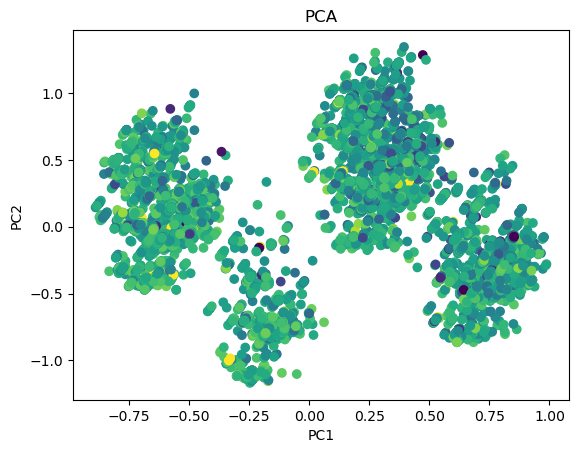

In [36]:
df_PCA = df.copy()

from sklearn import decomposition
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['mean_rating']), mean_rating_column, test_size=0.1, random_state=42)
print('X shape:',df.drop(columns=['mean_rating']).shape)
print('y shape:',mean_rating_column.shape)
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

pca = decomposition.PCA()
pca.fit(X_train)
print('pca.mean_:', pca.mean_)
print('pca.explained_variance_:', pca.explained_variance_)
print('pca.explained_variance_ratio_:', pca.explained_variance_ratio_)
print('pca.components_:', pca.components_)

X_train_t = pca.transform(X_train)
plt.scatter(X_train_t[:, 0], X_train_t[:, 1], c=y_train)
# add color legend
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA')
plt.show()


## Modeling

In [34]:
""" # Split data
df_to_use = df.copy()

df2 = df_to_use.copy()
X = df2.drop(columns=['mean_rating'])
y = df_to_use['mean_rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import tensorflow as tf

# Create the model using the Keras API of Tensorflow
model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model, specifying the loss function and optimizer
model.compile(loss='mean_squared_error', metrics=['mean_squared_error'], optimizer='adam')

# Train the model on the training data
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2)


# Evaluate the model on the test data
loss, mse = model.evaluate(X_test, y_test, verbose=0)
print('Loss: ', loss)
print('MSE: ', mse)

display(y_test[:5])
model.predict(X_test[:5]) """

" # Split data\ndf_to_use = df.copy()\n\ndf2 = df_to_use.copy()\nX = df2.drop(columns=['mean_rating'])\ny = df_to_use['mean_rating']\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\nimport tensorflow as tf\n\n# Create the model using the Keras API of Tensorflow\nmodel = tf.keras.Sequential([\n    tf.keras.layers.Dense(4, activation='relu', input_shape=(X_train.shape[1],)),\n    tf.keras.layers.Dense(16, activation='relu'),\n    tf.keras.layers.Dense(1)\n])\n\n# Compile the model, specifying the loss function and optimizer\nmodel.compile(loss='mean_squared_error', metrics=['mean_squared_error'], optimizer='adam')\n\n# Train the model on the training data\nhistory = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2)\n\n\n# Evaluate the model on the test data\nloss, mse = model.evaluate(X_test, y_test, verbose=0)\nprint('Loss: ', loss)\nprint('MSE: ', mse)\n\ndisplay(

In [35]:
""" import torch.nn as nn

# Split data
df2 = df.copy()
X = df2.drop(columns=['mean_rating'])
y = df['mean_rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Create the model using the torch
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 4),
    nn.ReLU(),
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

# Compile the model, specifying the loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model on the training data X_train and y_train
epochs = 20
for epoch in range(epochs):
    print('Epoch ', epoch)
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Evaluate the model on the test data
loss = loss_fn(model(X_test), y_test)
print('Loss: ', loss.item())

display(y_test[:5]) """


" import torch.nn as nn\n\n# Split data\ndf2 = df.copy()\nX = df2.drop(columns=['mean_rating'])\ny = df['mean_rating']\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Convert the data to tensors\nX_train = torch.tensor(X_train.values, dtype=torch.float32)\ny_train = torch.tensor(y_train.values, dtype=torch.float32)\nX_test = torch.tensor(X_test.values, dtype=torch.float32)\ny_test = torch.tensor(y_test.values, dtype=torch.float32)\n\n# Create the model using the torch\nmodel = nn.Sequential(\n    nn.Linear(X_train.shape[1], 4),\n    nn.ReLU(),\n    nn.Linear(4, 16),\n    nn.ReLU(),\n    nn.Linear(16, 1)\n)\n\n# Compile the model, specifying the loss function and optimizer\nloss_fn = nn.MSELoss()\noptimizer = torch.optim.Adam(model.parameters(), lr=1e-3)\n\n# Train the model on the training data X_train and y_train\nepochs = 20\nfor epoch in range(epochs):\n    print('Epoch ', epoch)\n    